In [1]:
import sys; sys.path.append("/iris/u/khatch/contrastive_rl")

import tensorflow as tf
import dill
import contrastive
from acme import specs
import jax
import jax.numpy as jnp
import functools
from collections import defaultdict

import os 
import numpy as np 
from metaworld.policies import SawyerLeverPullV2Policy, SawyerDialTurnV2Policy, SawyerPushV2Policy
import metaworld
from contrastive import utils as contrastive_utils
import env_utils
from glob import glob
from acme import specs
from tqdm import tqdm, trange
import cv2
import imageio
from mujoco_py import MjSimState
%matplotlib inline
from matplotlib import pyplot as plt
plt.rcParams['figure.figsize'] = [15, 5]

print("Finished imports.")

/iris/u/khatch/anaconda3/envs/contrastive_rl/lib/python3.9/site-packages/chex/_src/pytypes.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/iris/u/khatch/anaconda3/envs/contrastive_rl/lib/python3.9/site-packages/haiku/_src/data_structures.py:37: FutureWarning: jax.tree_structure is deprecated, and will be removed in a future release. Use jax.tree_util.tree_structure instead.
  PyTreeDef = type(jax.tree_structure(None))
/iris/u/khatch/anaconda3/envs/contrastive_rl/lib/python3.9/site-packages/gym/spaces/box.py:73: UserWarning: WARN: Box bound precision lowered by casting to float32
  logger.warn(


Finished imports.


In [22]:
"""
Make environment. 
"""

env_name = "offline_sawyer_drawer_randomxpos-goals"
# trial_dir = "/iris/u/khatch/contrastive_rl/results/example_based_control/offline_sawyer_drawer_randomxpos-goals/laeo/mr-bc0.5_b1024_1000ex/seed_3"
trial_dir = "/iris/u/khatch/contrastive_rl/results/max_logsumpexp/offline_sawyer_drawer_fixedxpos-goals/laeo/mr-bc0.5_b1024_75ex_logsumexp/seed_3"


env, obs_dim = contrastive_utils.make_environment(env_name, start_index=0, end_index=-1, seed=1)
qpos = env.data.qpos.flat.copy()
print("obs_dim:", obs_dim)
print("qpos.shape:", qpos.shape)
print("env._target_pos:", env._target_pos)
env.reset()
print("env._target_pos:", env._target_pos)
env.reset()
print("env._target_pos:", env._target_pos)
env.reset()
print("env._target_pos:", env._target_pos)

env.step(env.action_space.sample())

ep_length = 150


env_name: sawyer_drawer_randomxpos-goals
gym_env: <SawyerDrawerRandomXPosGoals instance>
kwargs: {}
obs_dim: 5
qpos.shape: (10,)
env._target_pos: [-0.15813394  0.73999998  0.09      ]
env._target_pos: [-0.08258602  0.73999998  0.09      ]
env._target_pos: [0.30249395 0.73999998 0.09      ]
env._target_pos: [-0.28769045  0.73999998  0.09      ]


In [3]:
successes = {}
returns = {}
min_dists = {}
all_dists = {}

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.01it/s]


mean return: 41.0
success rate: 1.0


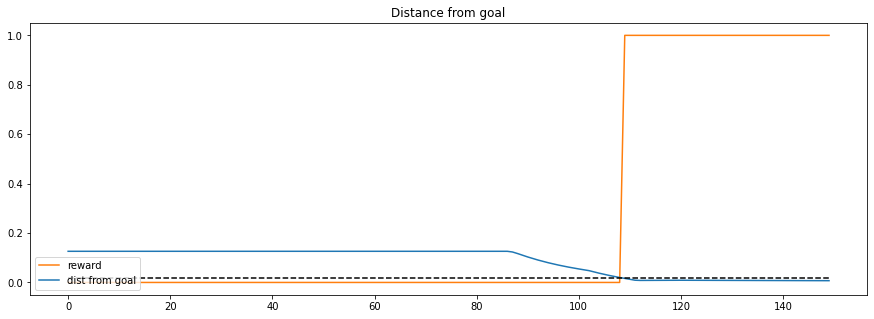

len(success_examples_close): 41
success_examples_close_images[-1]
Saving gifs...
Done saving gifs.


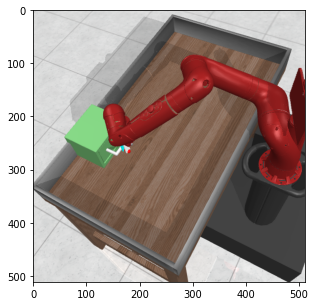

In [27]:
"""
Gather success examples for close task using a scripted policy
"""

from metaworld.policies import SawyerDrawerCloseV2Policy

policy = SawyerDrawerCloseV2Policy()

drawer_x_pos = 0.3

mode = "render" # "render" "eval"
n_episodes = 10

success_examples_close = []
success_examples_close_images = []
successes["close-scripted"] = []
returns["close-scripted"] = []
for ep_idx in range(1 if mode == "render" else n_episodes):
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    obj = env._get_pos_objects()
    policy_obs = np.concatenate([obs[:3], np.array([0]), obj])
    
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    for t in trange(ep_length):

        action = policy.get_action(policy_obs)
#         action = env.action_space.sample()
        _, reward, done, info = env.step(action)
        obs = env._get_obs()
        obj = env._get_pos_objects()
        policy_obs = np.concatenate([obs[:3], np.array([0]), obj])

        rewards.append(reward)
        
        s = obs[:obs_dim]
        g = obs[obs_dim:]
        
        drawer_pos = np.array([s[3], s[4], 0.09])
        drawer_pos_goal = np.array([g[3], g[4], 0.09])

        dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
        dists.append(dist)

        if mode == "render":
            env.sim.data.site_xpos[0] = 1_000_000
            image = env.sim.render(512, 512, camera_name="corner3")

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.8
            color = (255, 0, 255) # BGR
            thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)

            images.append(image)
            
            if reward > 0:
                success_examples_close.append(obs)
                success_examples_close_images.append(image)
            
    returns["close-scripted"].append(np.sum(rewards))
    successes["close-scripted"].append(np.sum(rewards) > 0)
    
print(f"mean return: {np.mean(returns['close-scripted'])}")
print(f"success rate: {np.mean(successes['close-scripted'])}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([0.02 for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    print("len(success_examples_close):", len(success_examples_close))
    print("success_examples_close_images[-1]")
    plt.imshow(success_examples_close_images[-1])
    cv2.imwrite("./gifs/close.png", success_examples_close_images[-1][..., ::-1])

    print("Saving gifs...")
    gif_filepath = './gifs/close/scripted.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
        

In [23]:
"""
Load the checkpoint, define the method to act and visualize q values
"""

filename = os.path.join(trial_dir, "checkpoints", "learner")
use_image_env = False 
repr_dim = 256
hidden_layer_sizes = (1024, 1024)
actor_min_std = 0.1
actor_obs_mode = "slice" # slice, zero, gc

reader = tf.train.load_checkpoint(filename)
params = reader.get_tensor('learner/.ATTRIBUTES/py_state')
state = dill.loads(params)

spec = specs.make_environment_spec(env)
networks = contrastive.make_networks(spec, obs_dim,
                             actor_min_std=actor_min_std,  # <-- Make sure this is the same value used for training.
                             repr_dim=repr_dim,
                             repr_norm=False,    
                             repr_norm_temp=True,
                             hidden_layer_sizes=hidden_layer_sizes,
                             twin_q=True,
                             use_image_obs=use_image_env,
                             slice_actor_goal=actor_obs_mode == "slice")




key = jax.random.PRNGKey(0)

@jax.jit
def _act(state, obs, goal_obs, key, data_action=None):
    actor_obs = obs.copy()
    if actor_obs_mode == "slice":
        actor_obs = actor_obs[:obs_dim] 
    elif actor_obs_mode == "zero":
        actor_obs = jnp.concatenate((actor_obs[:obs_dim], jnp.zeros_like(actor_obs[:obs_dim])), axis=0)
    elif actor_obs_mode == "gc":
        pass
    elif actor_obs_mode == "goal_obs":
        actor_obs[obs_dim:] = goal_obs
    else:
        raise ValueError(f"Unsupported actor_obs_mode: {actor_obs_mode}")

    dist_params = networks.policy_network.apply(state.policy_params, actor_obs[None])
    key, rng = jax.random.split(key, 2)
    mode_action = dist_params.mode()  # <-- Use this if you want to act deterministically
    sampled_action = networks.sample(dist_params, rng)
    
    critic_obs = obs.copy()
    critic_obs = jnp.concatenate((critic_obs[:obs_dim], goal_obs), axis=0)

    if data_action is None:
        q_pred_sampled = networks.q_network.apply(state.q_params, critic_obs[None], sampled_action)
        q_pred_mode = networks.q_network.apply(state.q_params, critic_obs[None], mode_action)
        return key, sampled_action[0], mode_action[0], np.min(q_pred_sampled), np.min(q_pred_mode)
    else:
        q_pred_sampled = networks.q_network.apply(state.q_params, critic_obs[None], sampled_action)
        q_pred_mode = networks.q_network.apply(state.q_params, critic_obs[None], mode_action)
        q_pred_data_action = networks.q_network.apply(state.q_params, critic_obs[None], data_action[None]) # (1, 1, 2)
        return key, np.min(q_pred_sampled), np.min(q_pred_mode), np.min(q_pred_data_action) # scalars
    
ts = env.reset()
_act(state, ts.observation, success_examples_close[-1][:obs_dim], key, data_action=np.zeros(4,))
# _act(state, ts.observation, success_examples_reach1[-1][:obs_dim], key, data_action=np.zeros(4,))


@functools.partial(jax.jit, static_argnames=("n", "act_dim", "act_low", "act_high"))
def _act_uniform_random(state, obs, goal_obs, act_dim, act_low, act_high, key, n=10):
    random_actions = jax.random.uniform(key, shape=(n, act_dim), minval=act_low, maxval=act_high) 
    
    critic_obs = obs.copy()
    critic_obs = jnp.concatenate((critic_obs[:obs_dim], goal_obs), axis=0)
    critic_obs_tiled = jnp.tile(critic_obs, (n, 1))
    
    q_preds = networks.q_network.apply(state.q_params, critic_obs_tiled, random_actions)
    if len(q_preds.shape) == 3:  # twin q trick
        assert q_preds.shape[2] == 2
        q_preds = jnp.min(q_preds, axis=-1)
    q_preds = jnp.diag(q_preds)
    
    max_idx = q_preds.argmax()
    action = random_actions[max_idx]
    q_pred = q_preds[max_idx]
    return key, action, q_pred


ts = env.reset()
key, action, q_pred = _act_uniform_random(state, ts.observation, success_examples_close[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, n=20)
# key, action, q_pred = _act_uniform_random(state, ts.observation, success_examples_reach1[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, n=20)
print("\nkey:", key)
print("action:", action)
print("q_pred:", q_pred)


@functools.partial(jax.jit, static_argnames=("act_dim", "act_low", "act_high", "K", "m_pop", "m_elite"))
def _act_cem(state, obs, goal_obs, act_dim, act_low, act_high, key, K=20, m_pop=100, m_elite=20):
    critic_obs = obs.copy()
    critic_obs = jnp.concatenate((critic_obs[:obs_dim], goal_obs), axis=0)
    critic_obs_tiled = jnp.tile(critic_obs, (m_pop, 1))
    
    
    
    initial_mean = jnp.zeros((act_dim,)) + ((act_low + act_high) / 2) 
    initial_cov = jnp.diag(jnp.zeros((act_dim,)) + (act_high - act_low))
    population_actions = jax.random.multivariate_normal(key, initial_mean, initial_cov, shape=(m_pop,))
    population_actions = jnp.clip(population_actions, act_low, act_high)
    
    
    iteration_most_elite_q_preds = []
    for i in range(K):
        q_preds = networks.q_network.apply(state.q_params, critic_obs_tiled, population_actions)
        if len(q_preds.shape) == 3:  # twin q trick
            assert q_preds.shape[2] == 2
            q_preds = jnp.min(q_preds, axis=-1)
        q_preds = jnp.diag(q_preds)
        
        idxs_high_to_low = jnp.argsort(q_preds)[::-1]
        elite_actions = population_actions[idxs_high_to_low]
        elite_actions = elite_actions[:m_elite]
        
        iteration_most_elite_q_preds.append(q_preds[idxs_high_to_low[0]])
        
        
        mean = elite_actions.mean(axis=0)
        cov = jnp.cov(elite_actions, rowvar=False)
        population_actions = jax.random.multivariate_normal(key, mean, cov, shape=(m_pop,))
        population_actions = jnp.clip(population_actions, act_low, act_high)
        
        
    
    
    action = elite_actions[0]
    iteration_most_elite_q_preds = jnp.stack(iteration_most_elite_q_preds, axis=0)
    return key, action, iteration_most_elite_q_preds


ts = env.reset()
key, action, iteration_most_elite_q_preds = _act_cem(state, ts.observation, success_examples_close[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=20, m_pop=100, m_elite=20)
# key, action, iteration_most_elite_q_preds = _act_cem(state, ts.observation, success_examples_reach1[-1][obs_dim:], env.action_space.shape[0], -1, 1, key, K=20, m_pop=100, m_elite=20)
print("\nkey:", key)
print("action:", action)
print("q_pred:", q_pred)


repr_norm: False, repr_norm_temp: True

key: [0 0]
action: [-0.81782603  0.9545505   0.5335016  -0.00824285]
q_pred: -242.44365

key: [0 0]
action: [nan nan nan nan]
q_pred: -242.44365


In [6]:
# """
# Evaluate policy network on close task
# """

# drawer_x_pos = 0.3
# mode = "render" # "render" "eval"
# n_episodes = 100

# successes['close-policy'] = []
# returns['close-policy'] = []
# for ep_idx in range(1 if mode == "render" else n_episodes):
#     rewards = []
#     dists = []
#     q_preds = []
#     images = []
    
#     env.set_drawer_xpos(drawer_x_pos)
#     env.reset()
    
#     obs = env._get_obs()
        
#     if mode == "render":
#         env.sim.data.site_xpos[0] = 1_000_000
#         image = env.sim.render(512, 512, camera_name="corner3")
#         images.append(image)
        
#     for t in trange(ep_length):
#         key, sampled_action, mode_action, q_sampled_a, q_mode_a = _act(state, obs, success_examples_close[-1][:obs_dim], key)
#         action = sampled_action.to_py()
        
#         q_preds.append(q_sampled_a.item())

#         _, reward, done, info = env.step(action)
#         obs = env._get_obs()


#         rewards.append(reward)
        
#         s = obs[:obs_dim]
#         g = obs[obs_dim:]
        
#         drawer_pos = np.array([s[3], s[4], 0.09])
#         drawer_pos_goal = np.array([g[3], g[4], 0.09])

#         dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
#         dists.append(dist)

#         if mode == "render":
#             env.sim.data.site_xpos[0] = 1_000_000
#             image = env.sim.render(512, 512, camera_name="corner3")

#             font = cv2.FONT_HERSHEY_SIMPLEX
#             fontScale = 0.8
#             color = (255, 0, 255) # BGR
#             thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)

#             images.append(image)
#     returns['close-policy'].append(np.sum(rewards))
#     successes['close-policy'].append(np.sum(rewards) > 0)
    
# print(f"mean return: {np.mean(returns['close-policy'])}")
# print(f"success rate: {np.mean(successes['close-policy'])}")
    
# if mode == "render":
#     plt.plot(rewards, label="reward", color="tab:orange")
#     plt.plot(dists, label="dist from goal", color="tab:blue")
#     plt.plot(np.array([0.02 for _ in range(len(rewards))]), color="black", ls='dashed')
#     plt.legend(loc='lower left')
#     plt.title("Distance from goal")
#     plt.show()
    
#     plt.plot(q_preds, label="Q", color="tab:red")
#     plt.legend(loc='lower left')
#     plt.title("Q preds")
#     plt.show()

    
#     print("Saving gifs...")
#     gif_filepath = './gifs/close/policy.gif'
#     os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
#     imageio.mimsave(gif_filepath, images)
#     print("Done saving gifs.")

In [7]:
# """
# Evaluate uniform random action selection with critic ranking on close task
# """

# print("success_examples_close[-1][:obs_dim]:", success_examples_close[-1][:obs_dim])

# drawer_x_pos = 0.3
# mode = "render" # "render" "eval"
# n_episodes = 100

# n = 10_000

# successes['close-uniform'] = []
# returns['close-uniform'] = []
# for ep_idx in range(1 if mode == "render" else n_episodes):
#     rewards = []
#     dists = []
#     q_preds = []
#     images = []
    
#     env.set_drawer_xpos(drawer_x_pos)
#     env.reset()
    
#     obs = env._get_obs()
    
        
#     if mode == "render":
#         env.sim.data.site_xpos[0] = 1_000_000
#         image = env.sim.render(512, 512, camera_name="corner3")
#         images.append(image)

#     for t in trange(ep_length):
#         key, action, q_pred = _act_uniform_random(state, obs, success_examples_close[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, n=n)
#         action = action.to_py()
        
#         q_preds.append(q_pred.item())

        
#         _, reward, done, info = env.step(action)
#         obs = env._get_obs()


#         rewards.append(reward)
        
#         s = obs[:obs_dim]
#         g = obs[obs_dim:]
        
#         drawer_pos = np.array([s[3], s[4], 0.09])
#         drawer_pos_goal = np.array([g[3], g[4], 0.09])

#         dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
#         dists.append(dist)

#         if mode == "render":
#             env.sim.data.site_xpos[0] = 1_000_000
#             image = env.sim.render(512, 512, camera_name="corner3")

#             font = cv2.FONT_HERSHEY_SIMPLEX
#             fontScale = 0.8
#             color = (255, 0, 255) # BGR
#             thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)

#             images.append(image)
#     returns['close-uniform'].append(np.sum(rewards))
#     successes['close-uniform'].append(np.sum(rewards) > 0)
    
# print(f"mean return: {np.mean(returns['close-uniform'])}")
# print(f"success rate: {np.mean(successes['close-uniform'])}")
    
# if mode == "render":
#     plt.plot(rewards, label="reward", color="tab:orange")
#     plt.plot(dists, label="dist from goal", color="tab:blue")
#     plt.plot(np.array([0.02 for _ in range(len(rewards))]), color="black", ls='dashed')
#     plt.legend(loc='lower left')
#     plt.title("Distance from goal")
#     plt.show()
    
#     plt.plot(q_preds, label="Q", color="tab:red")
#     plt.legend(loc='lower left')
#     plt.title("Q preds")
#     plt.show()

#     print("Saving gifs...")
#     gif_filepath = './gifs/close/uniform.gif'
#     os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
#     imageio.mimsave(gif_filepath, images)
#     print("Done saving gifs.")
    
    

success_examples_close[-1][:obs_dim]: [0.29873052 0.72196096 0.06936155 0.3        0.732855  ]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:44<00:00,  3.36it/s]

[1/1] mean return: 103.0, success rate: 1.0
Number of episodes skipped due to exception: 0
mean return: 103.0
success rate: 1.0
min dists: [0.007202029228210449]


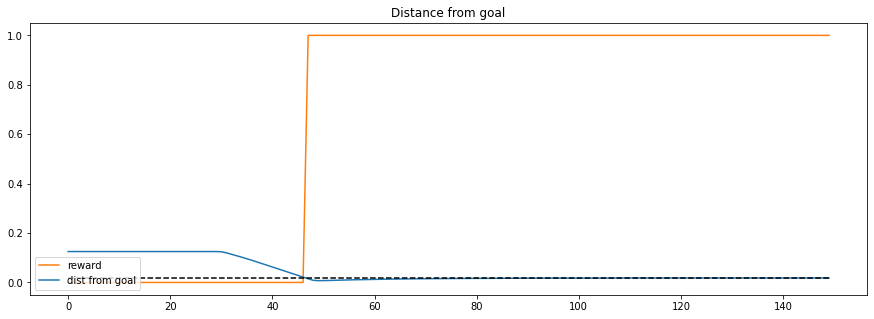

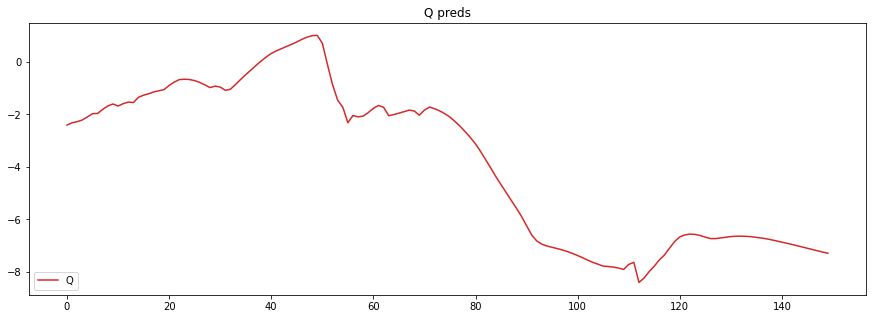

Saving gifs...
Done saving gifs.


In [30]:
"""
Evaluate CEM action selection with critic ranking on close task
"""

print("success_examples_close[-1][:obs_dim]:", success_examples_close[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "render" # "render" "eval"
# n_episodes = 100
n_episodes = 25 ###$$$###

# K = 10
# m_pop = 1_000
# m_elite = 200

K = 10 ###$$$###
m_pop = 10_000
m_elite = 2_000

successes['close-cem'] = []
returns['close-cem'] = []
min_dists['close-cem'] = []
all_dists['close-cem'] = []


# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            key, action, iteration_most_elite_q_preds = _act_cem(state, obs, success_examples_close[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=K, m_pop=m_pop, m_elite=m_elite)
            action = action.to_py()
            q_pred = iteration_most_elite_q_preds[-1]
            q_preds.append(q_pred.item())


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()


            rewards.append(reward)

            s = obs[:obs_dim]
            g = obs[obs_dim:]

            drawer_pos = np.array([s[3], s[4], 0.09])
            drawer_pos_goal = np.array([g[3], g[4], 0.09])

            dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
            dists.append(dist)
            

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 fontScale = 0.8
#                 color = (255, 0, 255) # BGR
#                 thickness = 2
#                 image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)

                images.append(image)
        returns['close-cem'].append(np.sum(rewards))
        successes['close-cem'].append(np.sum(rewards) > 0)
        min_dists['close-cem'].append(np.min(dists))
        all_dists['close-cem'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['close-cem'])}, success rate: {np.mean(successes['close-cem'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['close-cem'])}")
print(f"success rate: {np.mean(successes['close-cem'])}")
print(f"min dists: {min_dists['close-cem']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([0.02 for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    plt.plot(q_preds, label="Q", color="tab:red")
    plt.legend(loc='lower left')
    plt.title("Q preds")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/close/cem.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

In [9]:
"""
Evaluate random action selection on close task
"""

print("success_examples_close[-1][:obs_dim]:", success_examples_close[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "eval" # "render" "eval"
n_episodes = 25 ###$$$###

returns['close-rand'] = []
successes['close-rand'] = []
min_dists['close-rand'] = []
all_dists['close-rand'] = []


# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            action = env.action_space.sample()


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()


            rewards.append(reward)

            s = obs[:obs_dim]
            g = obs[obs_dim:]

            drawer_pos = np.array([s[3], s[4], 0.09])
            drawer_pos_goal = np.array([g[3], g[4], 0.09])

            dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
            dists.append(dist)
            

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
                image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
                               fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)

                images.append(image)
        returns['close-rand'].append(np.sum(rewards))
        successes['close-rand'].append(np.sum(rewards) > 0)
        min_dists['close-rand'].append(np.min(dists))
        all_dists['close-rand'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['close-rand'])}, success rate: {np.mean(successes['close-rand'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['close-rand'])}")
print(f"success rate: {np.mean(successes['close-rand'])}")
print(f"min dists: {min_dists['close-rand']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([0.02 for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/close/rand.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

success_examples_close[-1][:obs_dim]: [0.2987307  0.7219783  0.06936334 0.3        0.73286426]


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1929.86it/s]


[1/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1878.32it/s]


[2/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1924.19it/s]


[3/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1891.86it/s]


[4/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1912.33it/s]


[5/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1888.49it/s]


[6/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1868.80it/s]


[7/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1822.77it/s]


[8/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1809.42it/s]


[9/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1626.43it/s]


[10/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1876.19it/s]


[11/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1923.63it/s]


[12/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1914.76it/s]


[13/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1872.63it/s]


[14/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1875.40it/s]


[15/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1843.73it/s]


[16/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1758.99it/s]


[17/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1882.62it/s]


[18/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1852.23it/s]


[19/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1902.86it/s]


[20/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1907.58it/s]


[21/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1898.22it/s]


[22/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1928.76it/s]


[23/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1901.64it/s]


[24/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1856.85it/s]

[25/25] mean return: 0.0, success rate: 0.0
Number of episodes skipped due to exception: 0
mean return: 0.0
success rate: 0.0
min dists: [0.15700411796569824, 0.14871448278427124, 0.15640127658843994, 0.1473836898803711, 0.11149895191192627, 0.12900221347808838, 0.15649884939193726, 0.1441318392753601, 0.13245254755020142, 0.15668320655822754, 0.12236219644546509, 0.15032827854156494, 0.14683514833450317, 0.11460918188095093, 0.1291610598564148, 0.11421966552734375, 0.1297844648361206, 0.14025616645812988, 0.15324604511260986, 0.11864417791366577, 0.1534501314163208, 0.13089925050735474, 0.1370059847831726, 0.13548731803894043, 0.13831615447998047]


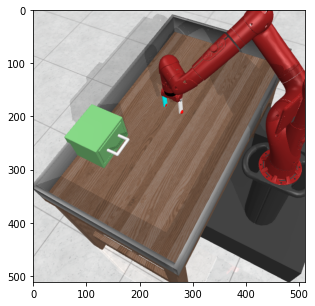

In [10]:
"""
Compute initial drawer position for open task
"""

env.set_drawer_xpos(drawer_x_pos)
env.reset()

env._set_obj_xyz(np.random.uniform(0, -0.01))

env.sim.data.site_xpos[0] = 1_000_000
image = env.sim.render(512, 512, camera_name="corner3")
plt.imshow(image)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.07it/s]


mean return: 3.0
success rate: 1.0


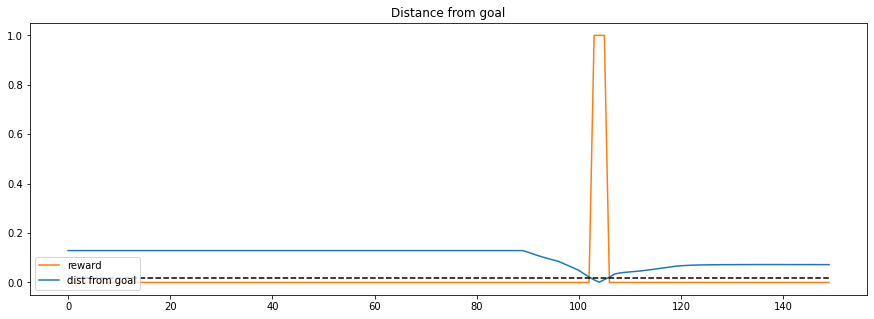

len(success_examples_open): 3
success_examples_open_images[-1]
Saving gifs...
Done saving gifs.


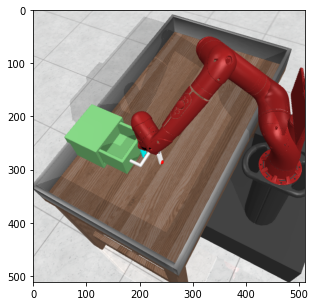

In [11]:
"""
Gather success examples for open task using a scripted policy
"""

from metaworld.policies import SawyerDrawerOpenV2Policy

policy = SawyerDrawerOpenV2Policy()

drawer_x_pos = 0.3

threshold = 0.02

mode = "render" # "render" "eval"
n_episodes = 10

success_examples_open = []
success_examples_open_images = []
successes['open-scripted'] = []
returns['open-scripted'] = []
for ep_idx in range(1 if mode == "render" else n_episodes):
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    env._set_obj_xyz(np.random.uniform(0, -0.01)) ### OPEN
    
    obs = env._get_obs()
    obj = env._get_pos_objects()
    policy_obs = np.concatenate([obs[:3], np.array([0]), obj])
    
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    for t in trange(ep_length):
        action = policy.get_action(policy_obs)
        _, reward, done, info = env.step(action)
        obs = env._get_obs()
        obj = env._get_pos_objects()
        policy_obs = np.concatenate([obs[:3], np.array([0]), obj])

        s = obs[:obs_dim]
        drawer_pos = np.array([s[3], s[4], 0.09])
        
        g = obs[obs_dim:]
        drawer_pos_goal = np.array([g[3], 0.6, 0.09]) ### OPEN

        dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
        dists.append(dist)
        
        reward = float(dist < threshold) ### OPEN
        rewards.append(reward)

        if mode == "render":
            env.sim.data.site_xpos[0] = 1_000_000
            image = env.sim.render(512, 512, camera_name="corner3")

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.8
            color = (255, 0, 255) # BGR
            thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
            
#             image = cv2.putText(image, f"drawer pos: [{drawer_pos[0]:.3f}, {drawer_pos[1]:.3f}, {drawer_pos[2]:.3f}]", (10, 170), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)

            images.append(image)
            
            if reward > 0:
                success_examples_open.append(obs)
                success_examples_open_images.append(image)
            
    returns['open-scripted'].append(np.sum(rewards))
    successes['open-scripted'].append(np.sum(rewards) > 0)
    
print(f"mean return: {np.mean(returns['open-scripted'])}")
print(f"success rate: {np.mean(successes['open-scripted'])}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    print("len(success_examples_open):", len(success_examples_open))
    print("success_examples_open_images[-1]")
    plt.imshow(success_examples_open_images[-1])
    cv2.imwrite("./gifs/open.png", success_examples_open_images[-1][..., ::-1])

    print("Saving gifs...")
    gif_filepath = './gifs/open/scripted.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
        

success_examples_open[-1][:obs_dim]: [0.28640285 0.56606543 0.08389541 0.3        0.5884769 ]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:49<00:00,  3.01it/s]


[1/1] mean return: 102.0, success rate: 1.0
Number of episodes skipped due to exception: 0
mean return: 102.0
success rate: 1.0
min dists: [0.0004699587821960227]


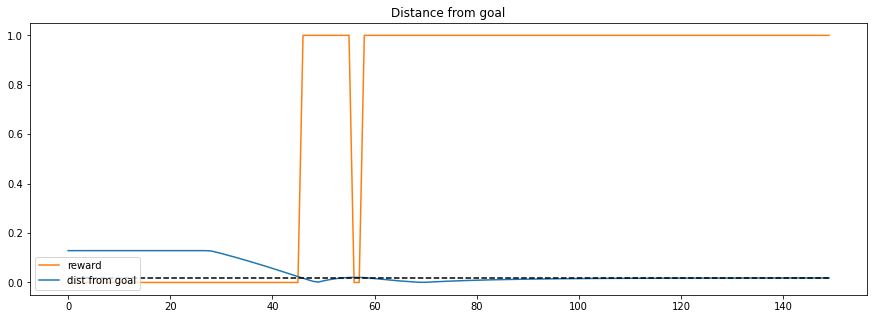

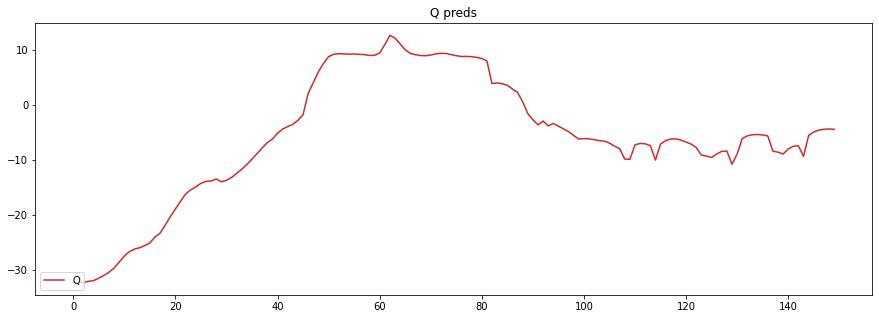

Saving gifs...
Done saving gifs.


In [12]:
"""
Evaluate CEM action selection with critic ranking on open task
"""

drawer_x_pos = 0.3
mode = "render" # "render" "eval"
n_episodes = 25 ###$$$###

threshold = 0.02

# K = 10
# m_pop = 1_000
# m_elite = 200

K = 10 ###$$$###
m_pop = 10_000
m_elite = 2_000

print("success_examples_open[-1][:obs_dim]:", success_examples_open[-1][:obs_dim])

successes['open-cem'] = []
returns['open-cem'] = []
min_dists['open-cem'] = []
all_dists['open-cem'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    env._set_obj_xyz(np.random.uniform(0, -0.01)) ### OPEN
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            key, action, iteration_most_elite_q_preds = _act_cem(state, obs, success_examples_open[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=K, m_pop=m_pop, m_elite=m_elite)
            action = action.to_py()
            q_pred = iteration_most_elite_q_preds[-1]
            q_preds.append(q_pred.item())


    #         if np.any(np.isnan(action)):
    #             print(f"action: {action}")
    #             import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            s = obs[:obs_dim]
            drawer_pos = np.array([s[3], s[4], 0.09])

            g = obs[obs_dim:]
            drawer_pos_goal = np.array([g[3], 0.6, 0.09]) ### OPEN

            dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold) ### OPEN
            rewards.append(reward)

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 fontScale = 0.8
#                 color = (255, 0, 255) # BGR
#                 thickness = 2
#                 image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)

                images.append(image)
        returns['open-cem'].append(np.sum(rewards))
        successes['open-cem'].append(np.sum(rewards) > 0)
        min_dists['open-cem'].append(np.min(dists))
        all_dists['open-cem'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['open-cem'])}, success rate: {np.mean(successes['open-cem'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['open-cem'])}")
print(f"success rate: {np.mean(successes['open-cem'])}")
print(f"min dists: {min_dists['open-cem']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    plt.plot(q_preds, label="Q", color="tab:red")
    plt.legend(loc='lower left')
    plt.title("Q preds")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/open/cem.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

In [13]:
"""
Evaluate random action selection on open task
"""

drawer_x_pos = 0.3
mode = "eval" # "render" "eval"
n_episodes = 25 ###$$$###
threshold - 0.02

print("success_examples_open[-1][:obs_dim]:", success_examples_open[-1][:obs_dim])

returns['open-rand'] = []
successes['open-rand'] = []
min_dists['open-rand'] = []
all_dists['open-rand'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    env._set_obj_xyz(np.random.uniform(0, -0.01)) ### OPEN
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            action = env.action_space.sample()


    #         if np.any(np.isnan(action)):
    #             print(f"action: {action}")
    #             import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            s = obs[:obs_dim]
            drawer_pos = np.array([s[3], s[4], 0.09])

            g = obs[obs_dim:]
            drawer_pos_goal = np.array([g[3], 0.6, 0.09]) ### OPEN

            dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold) ### OPEN
            rewards.append(reward)

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
                image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
                               fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)

                images.append(image)
        returns['open-rand'].append(np.sum(rewards))
        successes['open-rand'].append(np.sum(rewards) > 0)
        min_dists['open-rand'].append(np.min(dists))
        all_dists['open-rand'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['open-rand'])}, success rate: {np.mean(successes['open-rand'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['open-rand'])}")
print(f"success rate: {np.mean(successes['open-rand'])}")
print(f"min dists: {min_dists['open-rand']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/open/rand.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

success_examples_open[-1][:obs_dim]: [0.2861084 0.5592947 0.0839776 0.3       0.5821945]


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1217.17it/s]


[1/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1309.14it/s]


[2/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1133.41it/s]


[3/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1098.60it/s]


[4/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1035.29it/s]


[5/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1083.20it/s]


[6/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1706.19it/s]


[7/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1745.83it/s]


[8/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1721.31it/s]


[9/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1692.38it/s]


[10/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1707.72it/s]


[11/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1728.77it/s]


[12/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1691.85it/s]


[13/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1707.46it/s]


[14/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1737.98it/s]


[15/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1758.84it/s]


[16/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1324.16it/s]


[17/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1774.46it/s]


[18/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1778.70it/s]


[19/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1724.70it/s]


[20/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1727.46it/s]


[21/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1777.49it/s]


[22/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1767.70it/s]


[23/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1818.47it/s]


[24/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1804.71it/s]

[25/25] mean return: 0.0, success rate: 0.0
Number of episodes skipped due to exception: 0
mean return: 0.0
success rate: 0.0
min dists: [0.12309052944183352, 0.12796088457107546, 0.12943067550659182, 0.12972393035888674, 0.12488856315612795, 0.12290611267089846, 0.12918522357940676, 0.12303199768066408, 0.12175985574722292, 0.12933274507522585, 0.12605144977569582, 0.1252599596977234, 0.12226125001907351, 0.12996979951858523, 0.12854441404342654, 0.12010040283203127, 0.12750145196914675, 0.12735702991485598, 0.1246634364128113, 0.1248770594596863, 0.12972708940505984, 0.12309768199920657, 0.12423243522644045, 0.1275260090827942, 0.1207978963851929]


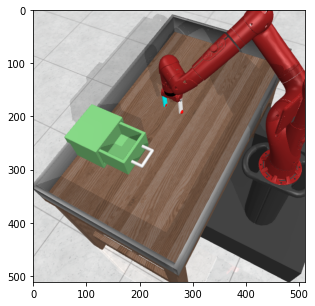

In [14]:
"""
Compute initial drawer position for open task
"""

env.set_drawer_xpos(drawer_x_pos)
env.reset()

env._set_obj_xyz(np.random.uniform(-0.15, -0.15))

env.sim.data.site_xpos[0] = 1_000_000
image = env.sim.render(512, 512, camera_name="corner3")
plt.imshow(image)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.08it/s]


mean return: 7.0
success rate: 1.0
Saving gifs...
Done saving gifs.


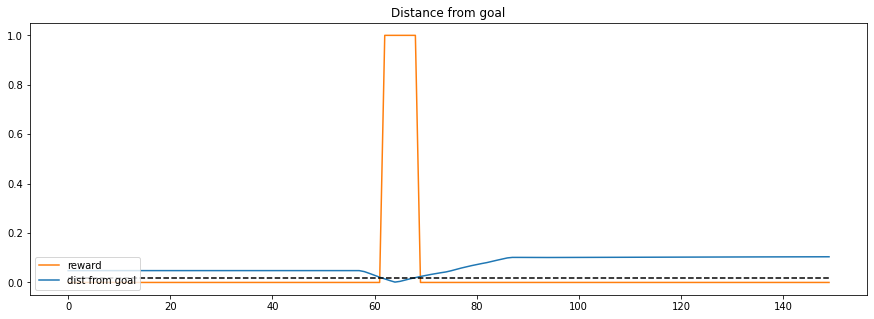

len(success_examples_halfclosed): 7
success_examples_halfclosed_images[-1]


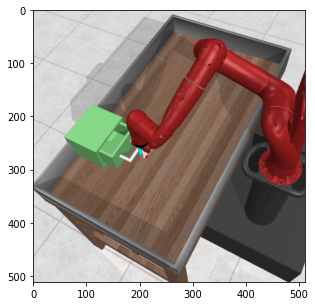

In [6]:
"""
Gather success examples for half closed task using a scripted policy
"""

from metaworld.policies import SawyerDrawerCloseV2Policy

policy = SawyerDrawerCloseV2Policy()

drawer_x_pos = 0.3
threshold = 0.02

mode = "render" # "render" "eval"
n_episodes = 10

success_examples_halfclosed = []
success_examples_halfclosed_images = []
successes['halfclosed-scripted'] = []
returns['halfclosed-scripted'] = []
for ep_idx in range(1 if mode == "render" else n_episodes):
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    env._set_obj_xyz(np.random.uniform(-0.14, -0.15)) ### HALF CLOSED
    
    obs = env._get_obs()
    obj = env._get_pos_objects()
    policy_obs = np.concatenate([obs[:3], np.array([0]), obj])
    
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    for t in trange(ep_length):
        action = policy.get_action(policy_obs)
        _, reward, done, info = env.step(action)
        obs = env._get_obs()
        obj = env._get_pos_objects()
        policy_obs = np.concatenate([obs[:3], np.array([0]), obj])

        s = obs[:obs_dim]
        drawer_pos = np.array([s[3], s[4], 0.09])
        
        g = obs[obs_dim:]
        drawer_pos_goal = np.array([g[3], 0.63, 0.09]) ### HALF CLOSED

        dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
        dists.append(dist)
        
        
        
        reward = float(dist < threshold) ### HALF CLOSED
        rewards.append(reward)

        if mode == "render":
            env.sim.data.site_xpos[0] = 1_000_000
            image = env.sim.render(512, 512, camera_name="corner3")

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.8
            color = (255, 0, 255) # BGR
            thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             print(f"[{t}] reward:", reward)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
            
#             image = cv2.putText(image, f"drawer pos: [{drawer_pos[0]:.3f}, {drawer_pos[1]:.3f}, {drawer_pos[2]:.3f}]", (10, 170), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)

            images.append(image)
            
            if reward > 0:
                success_examples_halfclosed.append(obs)
                success_examples_halfclosed_images.append(image)
            
    returns['halfclosed-scripted'].append(np.sum(rewards))
    successes['halfclosed-scripted'].append(np.sum(rewards) > 0)

    
print(f"mean return: {np.mean(returns['halfclosed-scripted'])}")
print(f"success rate: {np.mean(successes['halfclosed-scripted'])}")
    
if mode == "render":
    print("Saving gifs...")
    gif_filepath = './gifs/halfclosed/scripted.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    print("len(success_examples_halfclosed):", len(success_examples_halfclosed))
    print("success_examples_halfclosed_images[-1]")
    plt.imshow(success_examples_halfclosed_images[-1])
    cv2.imwrite("./gifs/halfclosed.png", success_examples_halfclosed_images[-1][..., ::-1])

    
        




success_examples_halfclosed[-1][:obs_dim]: [0.28718105 0.62144834 0.07647044 0.3        0.649659  ]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:44<00:00,  3.35it/s]

[1/1] mean return: 26.0, success rate: 1.0
Number of episodes skipped due to exception: 0
mean return: 26.0
success rate: 1.0
min dists: [0.0003331851959228471]


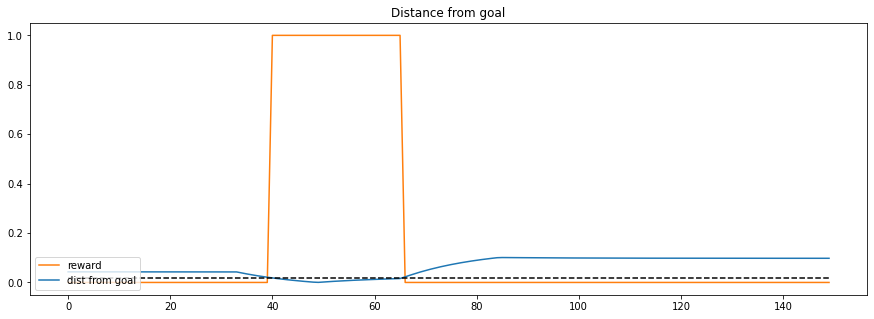

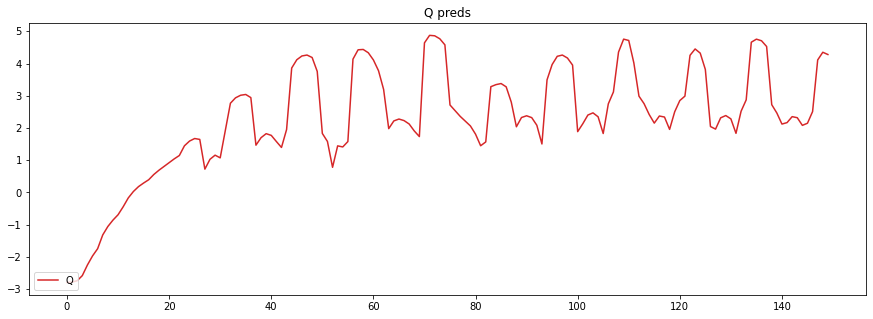

Saving gifs...
Done saving gifs.


In [26]:
"""
Evaluate CEM action selection with critic ranking on half closed task
"""

print("success_examples_halfclosed[-1][:obs_dim]:", success_examples_halfclosed[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "render" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.02

# K = 10
# m_pop = 1_000
# m_elite = 200

K = 10 ###$$$###
m_pop = 10_000
m_elite = 2_000

successes['halfclosed-cem'] = []
returns['halfclosed-cem'] = []
min_dists['halfclosed-cem'] = []
all_dists['halfclosed-cem'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    env._set_obj_xyz(np.random.uniform(-0.14, -0.15)) ### HALF CLOSED
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            key, action, iteration_most_elite_q_preds = _act_cem(state, obs, success_examples_halfclosed[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=K, m_pop=m_pop, m_elite=m_elite)
            action = action.to_py()
            q_pred = iteration_most_elite_q_preds[-1]
            q_preds.append(q_pred.item())


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            s = obs[:obs_dim]
            drawer_pos = np.array([s[3], s[4], 0.09])

            g = obs[obs_dim:]
            drawer_pos_goal = np.array([g[3], 0.63, 0.09]) ### HALF CLOSED

            dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold) ### OPEN
            rewards.append(reward)

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 fontScale = 0.8
#                 color = (255, 0, 255) # BGR
#                 thickness = 2
#                 image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)

                images.append(image)
        returns['halfclosed-cem'].append(np.sum(rewards))
        successes['halfclosed-cem'].append(np.sum(rewards) > 0)
        min_dists['halfclosed-cem'].append(np.min(dists))
        all_dists['halfclosed-cem'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['halfclosed-cem'])}, success rate: {np.mean(successes['halfclosed-cem'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['halfclosed-cem'])}")
print(f"success rate: {np.mean(successes['halfclosed-cem'])}")
print(f"min dists: {min_dists['halfclosed-cem']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    plt.plot(q_preds, label="Q", color="tab:red")
    plt.legend(loc='lower left')
    plt.title("Q preds")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/halfclosed/cem.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

In [17]:
"""
Evaluate random action selection on half closed task
"""

print("success_examples_halfclosed[-1][:obs_dim]:", success_examples_halfclosed[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "eval" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.02

successes['halfclosed-rand'] = []
returns['halfclosed-rand'] = []
min_dists['halfclosed-rand'] = []
all_dists['halfclosed-rand'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    env._set_obj_xyz(np.random.uniform(-0.14, -0.15)) ### HALF CLOSED
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            action = env.action_space.sample()

#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            s = obs[:obs_dim]
            drawer_pos = np.array([s[3], s[4], 0.09])

            g = obs[obs_dim:]
            drawer_pos_goal = np.array([g[3], 0.63, 0.09]) ### HALF CLOSED

            dist = np.linalg.norm(drawer_pos - drawer_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold) ### OPEN
            rewards.append(reward)

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
                image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
                               fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)

                images.append(image)
        returns['halfclosed-rand'].append(np.sum(rewards))
        successes['halfclosed-rand'].append(np.sum(rewards) > 0)
        min_dists['halfclosed-rand'].append(np.min(dists))
        all_dists['halfclosed-rand'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['halfclosed-rand'])}, success rate: {np.mean(successes['halfclosed-rand'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['halfclosed-rand'])}")
print(f"success rate: {np.mean(successes['halfclosed-rand'])}")
print(f"min dists: {min_dists['halfclosed-rand']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    

    print("Saving gifs...")
    gif_filepath = './gifs/halfclosed/rand.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

success_examples_halfclosed[-1][:obs_dim]: [0.288361   0.61673695 0.07491975 0.3        0.64586806]


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1896.16it/s]


[1/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1879.19it/s]


[2/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1862.56it/s]


[3/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1880.47it/s]


[4/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1832.37it/s]


[5/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1827.66it/s]


[6/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1835.84it/s]


[7/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1928.71it/s]


[8/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1821.07it/s]


[9/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1894.67it/s]


[10/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1892.94it/s]


[11/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1919.61it/s]


[12/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1874.26it/s]


[13/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1859.57it/s]


[14/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1813.39it/s]


[15/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1899.46it/s]


[16/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1871.61it/s]


[17/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1912.60it/s]


[18/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1892.04it/s]


[19/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1826.40it/s]


[20/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1847.83it/s]


[21/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1844.69it/s]


[22/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1840.12it/s]


[23/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1850.53it/s]


[24/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1846.80it/s]

[25/25] mean return: 0.0, success rate: 0.0
Number of episodes skipped due to exception: 0
mean return: 0.0
success rate: 0.0
min dists: [0.04395097970962525, 0.045306985378265385, 0.04507923603057862, 0.04106587648391724, 0.04787117719650269, 0.045510892868042, 0.048619692325592045, 0.047587518692016606, 0.049339060783386235, 0.04780531406402588, 0.04401869058609009, 0.04239315271377564, 0.0454316782951355, 0.04324138641357422, 0.043457036018371586, 0.04626858711242676, 0.04656231880187989, 0.04766774654388428, 0.045732741355896, 0.04251641511917115, 0.0483797836303711, 0.04946154832839966, 0.04255748271942139, 0.04895973682403565, 0.04397994756698609]


In [18]:
from metaworld.policies.action import Action
from metaworld.policies.policy import Policy, assert_fully_parsed, move



class SawyerDrawerReachV2Policy(Policy):
    def __init__(self, reach_goal, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self._reach_goal = reach_goal

    @staticmethod
#     @assert_fully_parsed
    def _parse_obs(obs):
        return {
            'hand_pos': obs[:3],
            'unused_1': obs[3],
            'door_pos': obs[4:7],
            'unused_2': obs[7:-3],
            'goal_pos': obs[-3:],
        }

    def get_action(self, obs):
        o_d = self._parse_obs(obs)

        action = Action({
            'delta_pos': np.arange(3),
            'grab_effort': 3
        })

        action['delta_pos'] = move(o_d['hand_pos'], to_xyz=self._reach_goal.copy(), p=25.)
        action['grab_effort'] = 1.

        return action.array

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.10it/s]


mean return: 127.0
success rate: 1.0


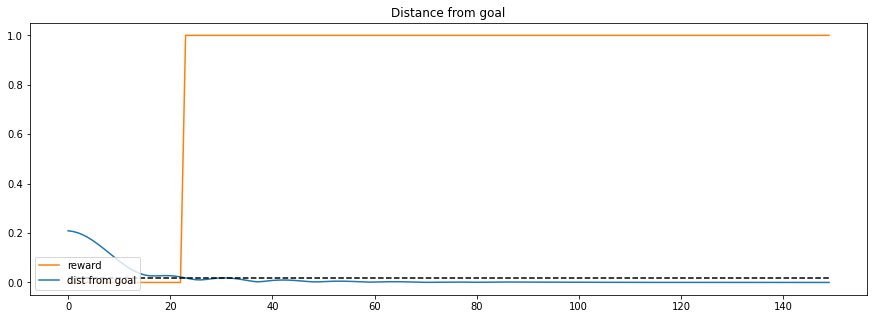

Saving gifs...
Done saving gifs.
len(success_examples_reach1): 127
success_examples_reach1_images[-1]


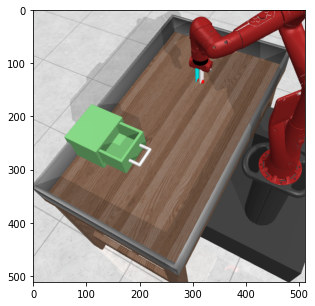

In [8]:
"""
Gather success examples for reach1 task using a scripted policy
"""


reach1_goal = np.array([-0.1, 0.5, 0.3]) ### REACH1
policy = SawyerDrawerReachV2Policy(reach1_goal)
# policy = SawyerDrawerCloseV2Policy()
threshold = 0.02

drawer_x_pos = 0.3

mode = "render" # "render" "eval"
n_episodes = 10

success_examples_reach1 = []
success_examples_reach1_images = []
successes['reach1-scripted'] = []
returns['reach1-scripted'] = []
for ep_idx in range(1 if mode == "render" else n_episodes):
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    obj = env._get_pos_objects()
    policy_obs = np.concatenate([obs[:3], np.array([0]), obj])
    
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    for t in trange(ep_length):
        action = policy.get_action(policy_obs)
        _, reward, done, info = env.step(action)
        obs = env._get_obs()
        obj = env._get_pos_objects()
        policy_obs = np.concatenate([obs[:3], np.array([0]), obj])

        ### REACH1
        s = obs[:obs_dim]
        tcp_center = s[:3] 
        
        tcp_center_pos_goal = reach1_goal.copy() 

        dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
        dists.append(dist)
        
        reward = float(dist < threshold)
        rewards.append(reward)
        ### REACH1

        if mode == "render":
            env.sim.data.site_xpos[0] = 1_000_000
            image = env.sim.render(512, 512, camera_name="corner3")

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.8
            color = (255, 0, 255) # BGR
            thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
#                                fontScale, color, thickness, cv2.LINE_AA) ### REACH1

            images.append(image)
            
            if reward > 0:
                success_examples_reach1.append(obs)
                success_examples_reach1_images.append(image)
            
    returns['reach1-scripted'].append(np.sum(rewards))
    successes['reach1-scripted'].append(np.sum(rewards) > 0)
    
print(f"mean return: {np.mean(returns['reach1-scripted'])}")
print(f"success rate: {np.mean(successes['reach1-scripted'])}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    

    print("Saving gifs...")
    gif_filepath = './gifs/reach1/scripted.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    print("len(success_examples_reach1):", len(success_examples_reach1))
    print("success_examples_reach1_images[-1]")
    plt.imshow(success_examples_reach1_images[-1])
    cv2.imwrite("./gifs/reach1.png", success_examples_reach1_images[-1][..., ::-1])
        




reach1_goal: [-0.1  0.5  0.3]
success_examples_reach1[-1][:obs_dim]: [-0.10002786  0.49997398  0.30000314  0.3         0.59402215]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:43<00:00,  3.45it/s]

[1/1] mean return: 16.0, success rate: 1.0
Number of episodes skipped due to exception: 0
mean return: 16.0
success rate: 1.0
min dists: [0.013249658903957932]


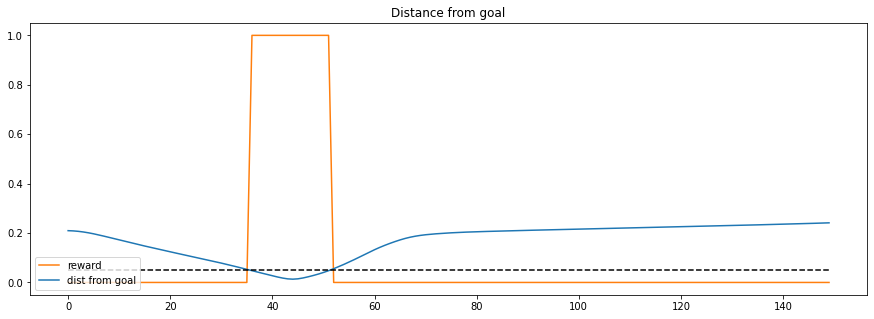

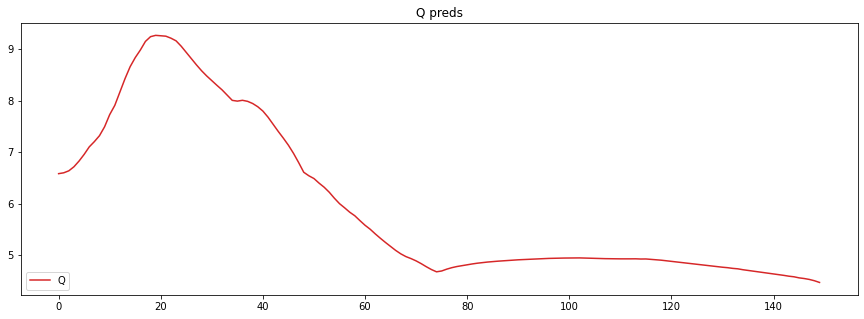

Saving gifs...
Done saving gifs.


In [10]:
"""
Evaluate CEM action selection with critic ranking on reach1 task
"""

# reach1_goal = np.array([-0.1, 0.5, 0.3]) ### REACH1
print("reach1_goal:", reach1_goal)
print("success_examples_reach1[-1][:obs_dim]:", success_examples_reach1[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "render" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.05

# K = 10
# m_pop = 1_000
# m_elite = 200

K = 10 ###$$$###
m_pop = 10_000
m_elite = 2_000

successes['reach1-cem'] = []
returns['reach1-cem'] = []
min_dists['reach1-cem'] = []
all_dists['reach1-cem'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            key, action, iteration_most_elite_q_preds = _act_cem(state, obs, success_examples_reach1[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=K, m_pop=m_pop, m_elite=m_elite)
            action = action.to_py()
            q_pred = iteration_most_elite_q_preds[-1]
            q_preds.append(q_pred.item())


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            ### REACH
            s = obs[:obs_dim]
            tcp_center = s[:3] 

            tcp_center_pos_goal = reach1_goal.copy() ### REACH1

            dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold)
            rewards.append(reward)
            ### REACH

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 fontScale = 0.8
#                 color = (255, 0, 255) # BGR
#                 thickness = 2
#                 image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA) ### REACH1

                images.append(image)
        returns['reach1-cem'].append(np.sum(rewards))
        successes['reach1-cem'].append(np.sum(rewards) > 0)
        min_dists['reach1-cem'].append(np.min(dists))
        all_dists['reach1-cem'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['reach1-cem'])}, success rate: {np.mean(successes['reach1-cem'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['reach1-cem'])}")
print(f"success rate: {np.mean(successes['reach1-cem'])}")
print(f"min dists: {min_dists['reach1-cem']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    plt.plot(q_preds, label="Q", color="tab:red")
    plt.legend(loc='lower left')
    plt.title("Q preds")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/reach1/cem.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

In [21]:
"""
Evaluate random action selection on reach1 task
"""

# reach1_goal = np.array([-0.1, 0.5, 0.3]) ### REACH1
print("reach1_goal:", reach1_goal)
print("success_examples_reach1[-1][:obs_dim]:", success_examples_reach1[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "eval" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.05

successes['reach1-rand'] = []
returns['reach1-rand'] = []
min_dists['reach1-rand'] = []
all_dists['reach1-rand'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            action = env.action_space.sample()


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            ### REACH
            s = obs[:obs_dim]
            tcp_center = s[:3] 

            tcp_center_pos_goal = reach1_goal.copy() ### REACH1

            dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold)
            rewards.append(reward)
            ### REACH

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
                image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
                               fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
                                   fontScale, color, thickness, cv2.LINE_AA) ### REACH1

                images.append(image)
        returns['reach1-rand'].append(np.sum(rewards))
        successes['reach1-rand'].append(np.sum(rewards) > 0)
        min_dists['reach1-rand'].append(np.min(dists))
        all_dists['reach1-rand'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['reach1-rand'])}, success rate: {np.mean(successes['reach1-rand'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['reach1-rand'])}")
print(f"success rate: {np.mean(successes['reach1-rand'])}")
print(f"min dists: {min_dists['reach1-rand']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/reach1/rand.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

reach1_goal: [-0.1  0.5  0.3]
success_examples_reach1[-1][:obs_dim]: [-0.10002786  0.49997398  0.30000314  0.3         0.59471077]


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1868.30it/s]


[1/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1737.76it/s]


[2/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1835.33it/s]


[3/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1875.12it/s]


[4/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1870.54it/s]


[5/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1878.82it/s]


[6/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1811.63it/s]


[7/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1876.22it/s]


[8/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1907.02it/s]


[9/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1789.79it/s]


[10/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1777.18it/s]


[11/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1802.02it/s]


[12/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1780.31it/s]


[13/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1807.40it/s]


[14/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1781.22it/s]


[15/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1841.48it/s]


[16/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1783.57it/s]


[17/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1709.50it/s]


[18/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1846.65it/s]


[19/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1803.25it/s]


[20/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1800.70it/s]


[21/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1820.51it/s]


[22/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1832.05it/s]


[23/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1800.36it/s]


[24/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1785.69it/s]

[25/25] mean return: 0.0, success rate: 0.0
Number of episodes skipped due to exception: 0
mean return: 0.0
success rate: 0.0
min dists: [0.13322622092726236, 0.20978102732988224, 0.195189086714582, 0.17962555641331365, 0.20949192518175164, 0.12341707333738898, 0.19361790466969248, 0.17473503012047137, 0.20465950099285768, 0.2013110576769739, 0.2081987487971608, 0.19731545104957748, 0.1480773511092491, 0.19697757922023434, 0.18911284675108606, 0.17105668965799348, 0.1616537174461583, 0.1476983630300522, 0.17167348288591613, 0.20964899600583412, 0.15301342998093218, 0.1293383005529839, 0.20079982821437262, 0.1251672295278992, 0.19203954578815544]


In [22]:
"""
Recompute succcess rate using a new distance threshold 
"""

print(f"Average min dist: {np.mean(min_dists['reach1-cem'])}")

new_dist_threshold = 0.05
new_successes = [min_dist < new_dist_threshold for min_dist in min_dists['reach1-cem']]
print(f"recomputed success rate (with dist threshold = {new_dist_threshold}): {np.mean(new_successes)}")

Average min dist: 0.0926924140476524
recomputed success rate (with dist threshold = 0.05): 0.0


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:24<00:00,  6.02it/s]


mean return: 128.0
success rate: 1.0


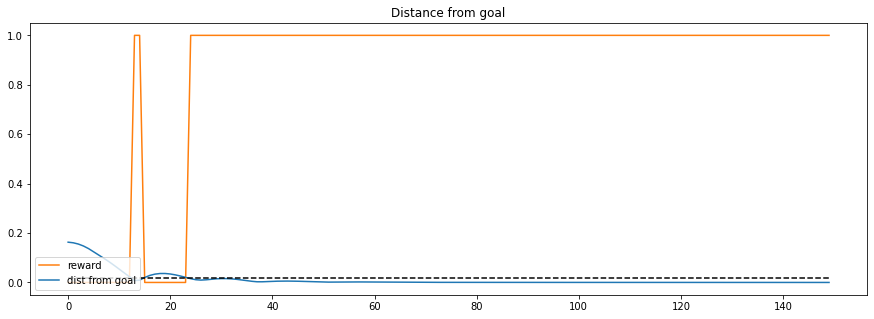

Saving gifs...
Done saving gifs.
len(success_examples_reach2): 128
success_examples_reach2_images[-1]


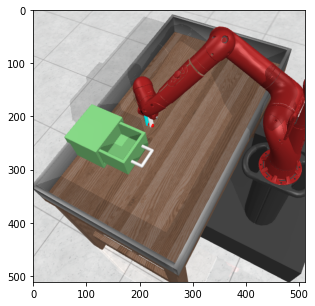

In [19]:
"""
Gather success examples for reach2 task using a scripted policy
"""


reach2_goal = np.array([0.1, 0.7, 0.06]) ### REACH2
policy = SawyerDrawerReachV2Policy(reach2_goal)
# policy = SawyerDrawerCloseV2Policy()

threshold = 0.02

drawer_x_pos = 0.3


mode = "render" # "render" "eval"
n_episodes = 10

success_examples_reach2 = []
success_examples_reach2_images = []
successes['reach2-scripted'] = []
returns['reach2-scripted'] = []
for ep_idx in range(1 if mode == "render" else n_episodes):
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    obj = env._get_pos_objects()
    policy_obs = np.concatenate([obs[:3], np.array([0]), obj])
    
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    for t in trange(ep_length):
        action = policy.get_action(policy_obs)
        _, reward, done, info = env.step(action)
        obs = env._get_obs()
        obj = env._get_pos_objects()
        policy_obs = np.concatenate([obs[:3], np.array([0]), obj])

        ### REACH
        s = obs[:obs_dim]
        tcp_center = s[:3] 
        
        tcp_center_pos_goal = reach2_goal.copy() ### REACH2

        dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
        dists.append(dist)
        
        reward = float(dist < threshold)
        rewards.append(reward)
        ### REACH
        
        if mode == "render":
            env.sim.data.site_xpos[0] = 1_000_000
            image = env.sim.render(512, 512, camera_name="corner3")

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.8
            color = (255, 0, 255) # BGR
            thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
#                                fontScale, color, thickness, cv2.LINE_AA) ### REACH

            images.append(image)
            
            if reward > 0:
                success_examples_reach2.append(obs)
                success_examples_reach2_images.append(image)
            
    returns['reach2-scripted'].append(np.sum(rewards))
    successes['reach2-scripted'].append(np.sum(rewards) > 0)
    
print(f"mean return: {np.mean(returns['reach2-scripted'])}")
print(f"success rate: {np.mean(successes['reach2-scripted'])}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    

    print("Saving gifs...")
    gif_filepath = './gifs/reach2/scripted.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    print("len(success_examples_reach2):", len(success_examples_reach2))
    print("success_examples_reach2_images[-1]")
    plt.imshow(success_examples_reach2_images[-1])
    cv2.imwrite("./gifs/reach2.png", success_examples_reach2_images[-1][..., ::-1])
        




reach2_goal: [0.1  0.7  0.06]
success_examples_reach2[-1][:obs_dim]: [0.10000268 0.7000032  0.05999911 0.3        0.5809144 ]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:50<00:00,  2.99it/s]

[1/1] mean return: 15.0, success rate: 1.0
Number of episodes skipped due to exception: 0
mean return: 15.0
success rate: 1.0
min dists: [0.017009559906498252]


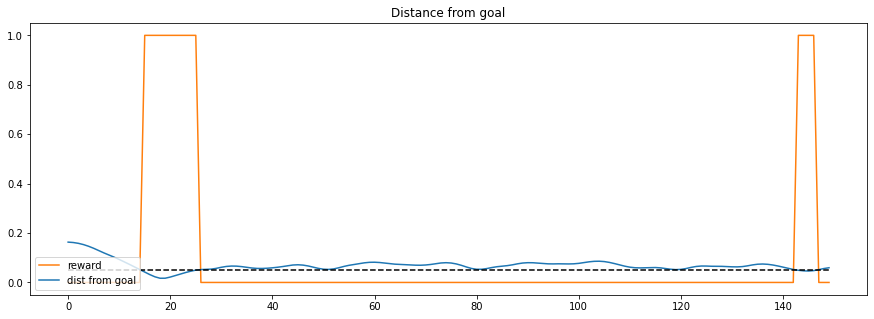

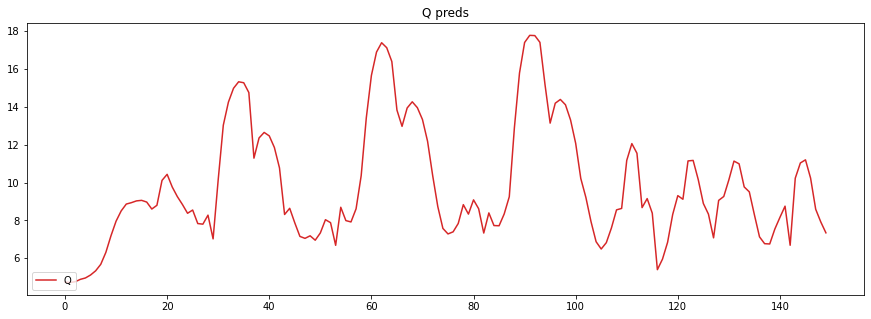

Saving gifs...
Done saving gifs.


In [20]:
"""
Evaluate CEM action selection with critic ranking on reach2 task
"""

# reach2_goal = np.array([0.1, 0.7, 0.06]) ### REACH2
print("reach2_goal:", reach2_goal)
print("success_examples_reach2[-1][:obs_dim]:", success_examples_reach2[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "render" # "render" "eval"
n_episodes = 25 ###$$$###

threshold = 0.05

# K = 10
# m_pop = 1_000
# m_elite = 200

K = 10 ###$$$###
m_pop = 10_000
m_elite = 2_000

successes['reach2-cem'] = []
returns['reach2-cem'] = []
min_dists['reach2-cem'] = []
all_dists['reach2-cem'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            key, action, iteration_most_elite_q_preds = _act_cem(state, obs, success_examples_reach2[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=K, m_pop=m_pop, m_elite=m_elite)
            action = action.to_py()
            q_pred = iteration_most_elite_q_preds[-1]
            q_preds.append(q_pred.item())


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            ### REACH
            s = obs[:obs_dim]
            tcp_center = s[:3] 

            tcp_center_pos_goal = reach2_goal.copy() ### REACH2

            dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold)
            rewards.append(reward)
            ### REACH

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

#                 font = cv2.FONT_HERSHEY_SIMPLEX
#                 fontScale = 0.8
#                 color = (255, 0, 255) # BGR
#                 thickness = 2
#                 image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA) ### REACH

                images.append(image)
        returns['reach2-cem'].append(np.sum(rewards))
        successes['reach2-cem'].append(np.sum(rewards) > 0)
        min_dists['reach2-cem'].append(np.min(dists))
        all_dists['reach2-cem'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['reach2-cem'])}, success rate: {np.mean(successes['reach2-cem'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['reach2-cem'])}")
print(f"success rate: {np.mean(successes['reach2-cem'])}")
print(f"min dists: {min_dists['reach2-cem']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    plt.plot(q_preds, label="Q", color="tab:red")
    plt.legend(loc='lower left')
    plt.title("Q preds")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/reach2/cem.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

In [25]:
"""
Evaluate random action selection on reach2 task
"""

# reach2_goal = np.array([0.1, 0.7, 0.06]) ### REACH2
print("reach2_goal:", reach2_goal)
print("success_examples_reach2[-1][:obs_dim]:", success_examples_reach2[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "eval" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.05

successes['reach2-rand'] = []
returns['reach2-rand'] = []
min_dists['reach2-rand'] = []
all_dists['reach2-rand'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            action = env.action_space.sample()


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            ### REACH
            s = obs[:obs_dim]
            tcp_center = s[:3] 

            tcp_center_pos_goal = reach2_goal.copy() ### REACH2

            dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold)
            rewards.append(reward)
            ### REACH

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
                image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
                               fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
                                   fontScale, color, thickness, cv2.LINE_AA) ### REACH

                images.append(image)
        returns['reach2-rand'].append(np.sum(rewards))
        successes['reach2-rand'].append(np.sum(rewards) > 0)
        min_dists['reach2-rand'].append(np.min(dists))
        all_dists['reach2-rand'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['reach2-rand'])}, success rate: {np.mean(successes['reach2-rand'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['reach2-rand'])}")
print(f"success rate: {np.mean(successes['reach2-rand'])}")
print(f"min dists: {min_dists['reach2-rand']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/reach2/rand.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

reach2_goal: [0.1  0.7  0.06]
success_examples_reach2[-1][:obs_dim]: [0.10000268 0.7000032  0.05999911 0.3        0.5926791 ]


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1860.98it/s]


[1/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1934.02it/s]


[2/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1902.16it/s]


[3/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1918.69it/s]


[4/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1884.39it/s]


[5/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1878.80it/s]


[6/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1886.04it/s]


[7/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1838.98it/s]


[8/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1817.96it/s]


[9/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1778.03it/s]


[10/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1897.89it/s]


[11/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1897.14it/s]


[12/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1926.78it/s]


[13/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1918.75it/s]


[14/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1877.69it/s]


[15/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1765.35it/s]


[16/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1806.89it/s]


[17/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1884.90it/s]


[18/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1919.55it/s]


[19/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1923.74it/s]


[20/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1722.54it/s]


[21/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1805.06it/s]


[22/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1890.38it/s]


[23/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1811.85it/s]


[24/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1757.93it/s]

[25/25] mean return: 0.0, success rate: 0.0
Number of episodes skipped due to exception: 0
mean return: 0.0
success rate: 0.0
min dists: [0.08100008405365629, 0.09890759717742842, 0.12280292385932914, 0.15267925351693198, 0.15607768324551072, 0.1573523652397785, 0.16361142281604346, 0.15076717983798793, 0.07041135974866486, 0.06127073136656267, 0.12087084711537165, 0.08351079713682658, 0.16418868813036938, 0.15335151953873138, 0.16410063604109398, 0.12802762464119385, 0.15496221125369306, 0.16157505735980016, 0.15312789279547073, 0.10081812146848197, 0.1373166670195994, 0.1635637862348819, 0.12258836741295619, 0.16354174468534882, 0.16398681537009685]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:25<00:00,  5.97it/s]


mean return: 134.0
success rate: 1.0


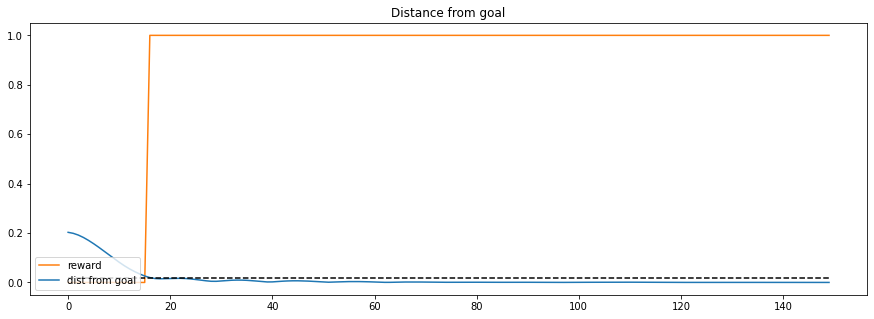

Saving gifs...
Done saving gifs.
len(success_examples_reach3): 134
success_examples_reach3_images[-1]


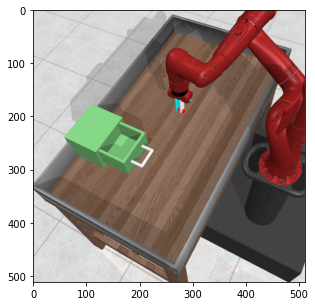

In [24]:
"""
Gather success examples for reach3 task using a scripted policy
"""


reach3_goal = np.array([0.1, 0.5, 0.3]) ### REACH3
policy = SawyerDrawerReachV2Policy(reach3_goal)

drawer_x_pos = 0.3
threshold = 0.02

mode = "render" # "render" "eval"
n_episodes = 10

success_examples_reach3 = []
success_examples_reach3_images = []
successes['reach3-scripted'] = []
returns['reach3-scripted'] = []
for ep_idx in range(1 if mode == "render" else n_episodes):
    rewards = []
    dists = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    obj = env._get_pos_objects()
    policy_obs = np.concatenate([obs[:3], np.array([0]), obj])
    
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    for t in trange(ep_length):
        action = policy.get_action(policy_obs)
        _, reward, done, info = env.step(action)
        obs = env._get_obs()
        obj = env._get_pos_objects()
        policy_obs = np.concatenate([obs[:3], np.array([0]), obj])

        ### REACH
        s = obs[:obs_dim]
        tcp_center = s[:3] 

        tcp_center_pos_goal = reach3_goal.copy() ### REACH 3

        dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
        dists.append(dist)

        reward = float(dist < threshold)
        rewards.append(reward)
        ### REACH

        if mode == "render":
            env.sim.data.site_xpos[0] = 1_000_000
            image = env.sim.render(512, 512, camera_name="corner3")

            font = cv2.FONT_HERSHEY_SIMPLEX
            fontScale = 0.8
            color = (255, 0, 255) # BGR
            thickness = 2
#             image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                            fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#             image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
#                                fontScale, color, thickness, cv2.LINE_AA) ### REACH

            images.append(image)

            if reward > 0:
                success_examples_reach3.append(obs)
                success_examples_reach3_images.append(image)

    returns['reach3-scripted'].append(np.sum(rewards))
    successes['reach3-scripted'].append(np.sum(rewards) > 0)
    
print(f"mean return: {np.mean(returns['reach3-scripted'])}")
print(f"success rate: {np.mean(successes['reach3-scripted'])}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    

    print("Saving gifs...")
    gif_filepath = './gifs/reach3/scripted.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    print("len(success_examples_reach3):", len(success_examples_reach3))
    print("success_examples_reach3_images[-1]")
    plt.imshow(success_examples_reach3_images[-1])
    cv2.imwrite("./gifs/reach3.png", success_examples_reach3_images[-1][..., ::-1])
        




reach3_goal: [0.1 0.5 0.3]
success_examples_reach3[-1][:obs_dim]: [0.0999937  0.49992988 0.30000952 0.3        0.5809144 ]


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 150/150 [00:50<00:00,  2.98it/s]

[1/1] mean return: 11.0, success rate: 1.0
Number of episodes skipped due to exception: 0
mean return: 11.0
success rate: 1.0
min dists: [0.04821293507170092]


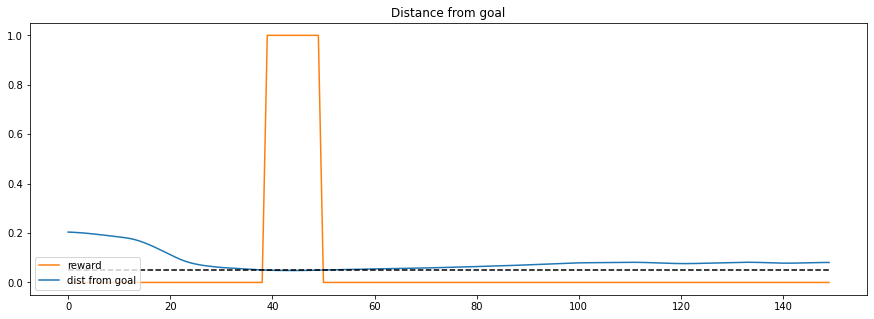

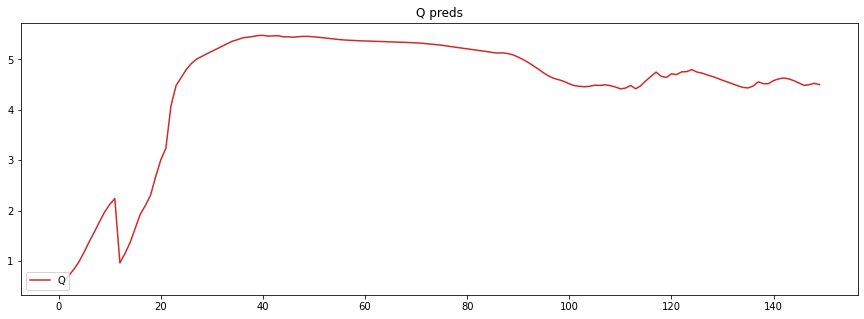

Saving gifs...
Done saving gifs.


In [25]:
"""
Evaluate CEM action selection with critic ranking on reach3 task
"""

print("reach3_goal:", reach3_goal)
print("success_examples_reach3[-1][:obs_dim]:", success_examples_reach3[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "render" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.05

# K = 10
# m_pop = 1_000
# m_elite = 200

K = 10 ###$$$###
m_pop = 10_000
m_elite = 2_000

successes['reach3-cem'] = []
returns['reach3-cem'] = []
min_dists['reach3-cem'] = []
all_dists['reach3-cem'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            key, action, iteration_most_elite_q_preds = _act_cem(state, obs, success_examples_reach3[-1][:obs_dim], env.action_space.shape[0], -1, 1, key, K=K, m_pop=m_pop, m_elite=m_elite)
            action = action.to_py()
            q_pred = iteration_most_elite_q_preds[-1]
            q_preds.append(q_pred.item())


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            ### REACH
            s = obs[:obs_dim]
            tcp_center = s[:3] 

            tcp_center_pos_goal = reach3_goal.copy() ### REACH3

            dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold)
            rewards.append(reward)
            ### REACH

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
#                 image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
#                                fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA)
#                 image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
#                                    fontScale, color, thickness, cv2.LINE_AA) ### REACH

                images.append(image)
        returns['reach3-cem'].append(np.sum(rewards))
        successes['reach3-cem'].append(np.sum(rewards) > 0)
        min_dists['reach3-cem'].append(np.min(dists))
        all_dists['reach3-cem'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['reach3-cem'])}, success rate: {np.mean(successes['reach3-cem'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['reach3-cem'])}")
print(f"success rate: {np.mean(successes['reach3-cem'])}")
print(f"min dists: {min_dists['reach3-cem']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    plt.plot(q_preds, label="Q", color="tab:red")
    plt.legend(loc='lower left')
    plt.title("Q preds")
    plt.show()

    print("Saving gifs...")
    gif_filepath = './gifs/reach3/cem.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

In [9]:
"""
Evaluate random action selection on reach3 task
"""

print("reach3_goal:", reach3_goal)
print("success_examples_reach3[-1][:obs_dim]:", success_examples_reach3[-1][:obs_dim])

drawer_x_pos = 0.3
mode = "eval" # "render" "eval"
n_episodes = 25 ###$$$###
threshold = 0.05

successes['reach3-rand'] = []
returns['reach3-rand'] = []
min_dists['reach3-rand'] = []
all_dists['reach3-rand'] = []

# for ep_idx in range(1 if mode == "render" else n_episodes):
n_skipped = 0
ep_idx = 0
max_eps = 1 if mode == "render" else n_episodes
while ep_idx < max_eps: ###$$$###
    rewards = []
    dists = []
    q_preds = []
    images = []
    
    env.set_drawer_xpos(drawer_x_pos)
    env.reset()
    
    obs = env._get_obs()
    
        
    if mode == "render":
        env.sim.data.site_xpos[0] = 1_000_000
        image = env.sim.render(512, 512, camera_name="corner3")
        images.append(image)
        
    try: ###$$$###
        for t in trange(ep_length):
            action = env.action_space.sample()


#             if np.any(np.isnan(action)):
#                 print(f"action: {action}")
#                 import pdb; pdb.set_trace()
            if np.any(np.isnan(action)): ###$$$###
                print(f"ep idx {ep_idx} [{f}] action: {action}")

            _, reward, done, info = env.step(action)
            obs = env._get_obs()

            ### REACH
            s = obs[:obs_dim]
            tcp_center = s[:3] 

            tcp_center_pos_goal = reach3_goal.copy() ### REACH3

            dist = np.linalg.norm(tcp_center - tcp_center_pos_goal)
            dists.append(dist)

            reward = float(dist < threshold)
            rewards.append(reward)
            ### REACH

            if mode == "render":
                env.sim.data.site_xpos[0] = 1_000_000
                image = env.sim.render(512, 512, camera_name="corner3")

                font = cv2.FONT_HERSHEY_SIMPLEX
                fontScale = 0.8
                color = (255, 0, 255) # BGR
                thickness = 2
                image = cv2.putText(image, f"t: {t + 1}/{ep_length}", (10, 50), font, 
                               fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"rew: {reward:.3f}", (10, 90), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"dist: {dist:.3f}", (10, 130), font, 
                                   fontScale, color, thickness, cv2.LINE_AA)
                image = cv2.putText(image, f"tcp_center pos: [{tcp_center[0]:.3f}, {tcp_center[1]:.3f}, {tcp_center[2]:.3f}]", (10, 170), font, 
                                   fontScale, color, thickness, cv2.LINE_AA) ### REACH

                images.append(image)
        returns['reach3-rand'].append(np.sum(rewards))
        successes['reach3-rand'].append(np.sum(rewards) > 0)
        min_dists['reach3-rand'].append(np.min(dists))
        all_dists['reach3-rand'].append(dists)
        ep_idx += 1 ###$$$###
        
    except: ###$$$###
        n_skipped += 1
        print(f"Skipping episode due to exception. Total skipped so far: {n_skipped}")
        
            
    print(f"[{ep_idx}/{max_eps}] mean return: {np.mean(returns['reach3-rand'])}, success rate: {np.mean(successes['reach3-rand'])}") ###$$$###
             
                
print(f"Number of episodes skipped due to exception: {n_skipped}") ###$$$###
    
print(f"mean return: {np.mean(returns['reach3-rand'])}")
print(f"success rate: {np.mean(successes['reach3-rand'])}")
print(f"min dists: {min_dists['reach3-rand']}")
    
if mode == "render":
    plt.plot(rewards, label="reward", color="tab:orange")
    plt.plot(dists, label="dist from goal", color="tab:blue")
    plt.plot(np.array([threshold for _ in range(len(rewards))]), color="black", ls='dashed')
    plt.legend(loc='lower left')
    plt.title("Distance from goal")
    plt.show()
    
    print("Saving gifs...")
    gif_filepath = './gifs/reach3/rand.gif'
    os.makedirs(os.path.dirname(gif_filepath), exist_ok=True)
    imageio.mimsave(gif_filepath, images)
    print("Done saving gifs.")
    
    

reach3_goal: [0.1 0.5 0.3]
success_examples_reach3[-1][:obs_dim]: [0.0999937  0.49992988 0.30000952 0.3        0.59402215]


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1785.71it/s]


[1/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1874.36it/s]


[2/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1875.59it/s]


[3/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1895.94it/s]


[4/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1859.17it/s]


[5/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1821.00it/s]


[6/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1868.10it/s]


[7/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1818.32it/s]


[8/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1816.53it/s]


[9/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1794.02it/s]


[10/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1853.60it/s]


[11/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1871.27it/s]


[12/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1697.24it/s]


[13/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1356.51it/s]


[14/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1562.19it/s]


[15/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1846.27it/s]


[16/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1866.08it/s]


[17/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1873.44it/s]


[18/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1851.35it/s]


[19/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1846.58it/s]


[20/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1883.20it/s]


[21/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1817.53it/s]


[22/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1895.17it/s]


[23/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1862.78it/s]


[24/25] mean return: 0.0, success rate: 0.0


100%|█████████████████████████████████████████████████████████████| 150/150 [00:00<00:00, 1849.55it/s]

[25/25] mean return: 0.0, success rate: 0.0
Number of episodes skipped due to exception: 0
mean return: 0.0
success rate: 0.0
min dists: [0.20447536082748138, 0.19736608005394793, 0.1909610886128265, 0.20419632071767738, 0.1683789828849069, 0.20384635828921394, 0.10895816980645918, 0.20411299435322056, 0.20464593837082032, 0.20285676007291298, 0.15024826394443197, 0.15865820071689812, 0.14194472888068604, 0.14197486583667196, 0.1759230750547885, 0.20401915452707142, 0.15555283095011102, 0.05147018057763587, 0.2039930165417698, 0.14946993633601333, 0.20120069392458106, 0.18977129695964257, 0.2019000081141276, 0.1434862337679307, 0.17074938867833928]


In [29]:
"""
Recompute succcess rate using a new distance threshold 
"""

print(f"Average min dist: {np.mean(min_dists['reach3-rand'])}")

new_dist_threshold = 0.1
new_successes = [min_dist < new_dist_threshold for min_dist in min_dists['reach3-rand']]
print(f"recomputed success rate (with dist threshold = {new_dist_threshold}): {np.mean(new_successes)}")

Average min dist: 0.17020203313238155
recomputed success rate (with dist threshold = 0.1): 0.0


In [30]:
min_dists['reach3-rand']

[0.2044509480208001,
 0.10467848653464405,
 0.20391333874673243,
 0.18165628079300775,
 0.14490905348154842,
 0.12986285157006797,
 0.1661251356775253,
 0.19233636229962517,
 0.1664749047599103,
 0.1603354434114586,
 0.20437903772935853,
 0.199527215006654,
 0.16817579476655362,
 0.19208664488823574,
 0.1621977133075975,
 0.11788990221155528,
 0.2033385019547785,
 0.1987736602572218,
 0.18126236252902378,
 0.1204693896582797,
 0.2019901098800479,
 0.20065708194310805,
 0.19497378331692117,
 0.1058004241205638,
 0.14878640144431926]